In [5]:
import os
import pandas as pd
import re

print("Current working directory:")
print(os.getcwd())

DATA_DIR = "../data"

print("\nFiles in data folder:")
print(os.listdir(DATA_DIR))


Current working directory:
C:\Users\sherl\review_trend_agent\notebooks

Files in data folder:
['.ipynb_checkpoints', 'all_reviews.csv']


In [6]:
csv_path = os.path.join(DATA_DIR, "all_reviews.csv")
df = pd.read_csv(csv_path)

print("Data loaded successfully")
print("Shape:", df.shape)

df.head()


Data loaded successfully
Shape: (200, 12)


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,date
0,7cf3ecd1-6712-40db-a0c1-5fb71f8fae58,Festr Rest,https://play-lh.googleusercontent.com/a/ACg8oc...,sometimes I didn't get my order but after 2 or...,4,0,4.99.0,2025-12-24 22:25:37,"Hey, thank you for your feedback. We request y...",2025-12-24 22:34:00,4.99.0,2025-12-24
1,34452425-f95d-4c80-b9f4-0b207345c82b,Rupali Salvi,https://play-lh.googleusercontent.com/a/ACg8oc...,best service,5,0,4.97.1,2025-12-24 22:25:33,"Hey there, thank you for the valuable feedback...",2025-12-24 22:33:56,4.97.1,2025-12-24
2,502fb7b7-c2d4-4c36-8e3a-69fc9afa67b0,Bhagya Doddagoudar,https://play-lh.googleusercontent.com/a/ACg8oc...,good,5,0,4.99.0,2025-12-24 22:23:52,"Hey there, thank you for the valuable feedback...",2025-12-24 22:33:51,4.99.0,2025-12-24
3,b976f6d9-9569-471b-a9e5-b9eb73d60e54,Naiki Hembram,https://play-lh.googleusercontent.com/a/ACg8oc...,so lovely app,3,0,4.99.0,2025-12-24 22:21:51,"Hey there, thank you for the valuable feedback...",2025-12-24 22:22:34,4.99.0,2025-12-24
4,f9fdc332-de3c-47a0-8c73-963d24502ec4,Sabir Alam,https://play-lh.googleusercontent.com/a/ACg8oc...,Neither the goods arrive quickly nor the calls...,1,1,4.99.0,2025-12-24 22:20:13,"Hi, we are sorry about this. Please help us wi...",2025-12-24 22:22:34,4.99.0,2025-12-24


In [7]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)     # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)    # keep only letters
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_content"] = df["content"].apply(clean_text)

df[["content", "clean_content"]].head()


,content,clean_content
0,sometimes I didn't get my order but after 2 or...,sometimes i didnt get my order but after or ho...
1,best service,best service
2,good,good
3,so lovely app,so lovely app
4,Neither the goods arrive quickly nor the calls...,neither the goods arrive quickly nor the calls...


In [8]:
df["date"] = pd.to_datetime(df["date"])
print(df["date"].min(), "→", df["date"].max())


2025-12-24 00:00:00 → 2025-12-24 00:00:00


In [11]:
import pandas as pd
import numpy as np
from collections import defaultdict
from datetime import datetime
import re

class TopicExtractionAgent:
    """
    Agent 1: Extracts topics from reviews on a per-day basis.
    High recall approach - captures all potential topics/themes.
    """
    
    def __init__(self, df):
        """
        Initialize with cleaned DataFrame
        df should have: date, clean_content, score columns
        """
        self.df = df.copy()
        self.daily_topics = {}
        self.topic_keywords = defaultdict(list)
        
    def extract_keywords(self, text, min_length=3):
        """
        Extract potential topic keywords from text.
        Simple but effective approach for high recall.
        """
        words = text.split()
        
        # Filter meaningful words
        keywords = [
            w for w in words 
            if len(w) >= min_length and w not in self.get_stopwords()
        ]
        
        # Extract bi-grams (two-word phrases)
        bigrams = [
            f"{words[i]} {words[i+1]}"
            for i in range(len(words)-1)
            if len(words[i]) >= min_length and len(words[i+1]) >= min_length
        ]
        
        return keywords, bigrams
    
    def get_stopwords(self):
        """Common stopwords to filter out"""
        return {
            'the', 'is', 'at', 'which', 'on', 'a', 'an', 'and', 'or',
            'but', 'in', 'with', 'to', 'for', 'of', 'as', 'by', 'this',
            'that', 'it', 'from', 'be', 'are', 'was', 'were', 'been',
            'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
            'could', 'should', 'may', 'might', 'can', 'their', 'they',
            'them', 'we', 'our', 'you', 'your', 'my', 'me', 'i'
        }
    
    def analyze_sentiment_context(self, text, keyword):
        """
        Extract sentiment context around a keyword.
        Returns positive/negative indicators and surrounding words.
        """
        # Sentiment indicators
        positive_words = {
            'good', 'great', 'excellent', 'amazing', 'love', 'best',
            'perfect', 'wonderful', 'fantastic', 'awesome', 'helpful',
            'friendly', 'clean', 'comfortable', 'nice', 'beautiful'
        }
        
        negative_words = {
            'bad', 'poor', 'terrible', 'awful', 'hate', 'worst',
            'disappointing', 'dirty', 'broken', 'rude', 'uncomfortable',
            'noisy', 'small', 'expensive', 'cold', 'old', 'issue', 'problem'
        }
        
        words = text.split()
        sentiment = {'positive': 0, 'negative': 0, 'context': []}
        
        # Find keyword position and get context window
        for i, word in enumerate(words):
            if keyword in word or word in keyword:
                start = max(0, i - 5)
                end = min(len(words), i + 6)
                context = words[start:end]
                
                for ctx_word in context:
                    if ctx_word in positive_words:
                        sentiment['positive'] += 1
                    if ctx_word in negative_words:
                        sentiment['negative'] += 1
                
                sentiment['context'] = ' '.join(context)
                break
        
        return sentiment
    
    def process_day(self, date, reviews_df):
        """
        Process all reviews for a single day.
        Returns topics with frequency and sentiment.
        """
        topics = defaultdict(lambda: {
            'count': 0,
            'positive_context': 0,
            'negative_context': 0,
            'avg_score': [],
            'examples': []
        })
        
        for idx, row in reviews_df.iterrows():
            text = row['clean_content']
            score = row.get('score', 0)
            
            # Extract keywords and bigrams
            keywords, bigrams = self.extract_keywords(text)
            
            # Process single-word topics
            for keyword in keywords:
                sentiment = self.analyze_sentiment_context(text, keyword)
                topics[keyword]['count'] += 1
                topics[keyword]['positive_context'] += sentiment['positive']
                topics[keyword]['negative_context'] += sentiment['negative']
                topics[keyword]['avg_score'].append(score)
                
                if len(topics[keyword]['examples']) < 2:
                    topics[keyword]['examples'].append(sentiment['context'][:100])
            
            # Process two-word topics (usually more meaningful)
            for bigram in bigrams:
                sentiment = self.analyze_sentiment_context(text, bigram)
                topics[bigram]['count'] += 1
                topics[bigram]['positive_context'] += sentiment['positive']
                topics[bigram]['negative_context'] += sentiment['negative']
                topics[bigram]['avg_score'].append(score)
                
                if len(topics[bigram]['examples']) < 2:
                    topics[bigram]['examples'].append(sentiment['context'][:100])
        
        # Calculate average scores
        for topic in topics:
            scores = topics[topic]['avg_score']
            topics[topic]['avg_score'] = np.mean(scores) if scores else 0
        
        # Filter to keep only topics mentioned multiple times (threshold = 2)
        filtered_topics = {
            k: v for k, v in topics.items() 
            if v['count'] >= 2
        }
        
        return filtered_topics
    
    def extract_all_topics(self, min_mentions=2):
        """
        Main method: Extract topics for each day in the dataset.
        Returns dictionary: {date: {topic: stats}}
        """
        # Group by date
        self.df['date'] = pd.to_datetime(self.df['date'])
        grouped = self.df.groupby(self.df['date'].dt.date)
        
        print(f"Processing {len(grouped)} days of reviews...")
        
        for date, day_reviews in grouped:
            print(f"\nProcessing {date}: {len(day_reviews)} reviews")
            
            topics = self.process_day(date, day_reviews)
            
            # Store results
            self.daily_topics[date] = topics
            
            # Print top topics for this day
            sorted_topics = sorted(
                topics.items(), 
                key=lambda x: x[1]['count'], 
                reverse=True
            )[:5]
            
            print(f"  Top topics: {[t[0] for t in sorted_topics]}")
        
        return self.daily_topics
    
    def get_summary_df(self):
        """
        Convert results to a summary DataFrame for analysis.
        """
        rows = []
        
        for date, topics in self.daily_topics.items():
            for topic, stats in topics.items():
                rows.append({
                    'date': date,
                    'topic': topic,
                    'mentions': stats['count'],
                    'avg_score': stats['avg_score'],
                    'positive_signals': stats['positive_context'],
                    'negative_signals': stats['negative_context'],
                    'sentiment_ratio': (
                        stats['positive_context'] / max(1, stats['negative_context'])
                    ),
                    'example': stats['examples'][0] if stats['examples'] else ''
                })
        
        return pd.DataFrame(rows)


# =============================================================================
# USAGE EXAMPLE
# =============================================================================

# Initialize agent with your DataFrame
agent = TopicExtractionAgent(df)

# Extract topics for all days
daily_topics = agent.extract_all_topics(min_mentions=2)

# Get summary as DataFrame
summary_df = agent.get_summary_df()

# View results
print("\n" + "="*60)
print("TOPIC EXTRACTION COMPLETE")
print("="*60)
print(f"\nTotal unique topics found: {summary_df['topic'].nunique()}")
print(f"Total topic mentions: {summary_df['mentions'].sum()}")

# Show top topics overall
print("\n📊 TOP 10 TOPICS (by total mentions):")
top_topics = summary_df.groupby('topic')['mentions'].sum().sort_values(ascending=False).head(10)
print(top_topics)

# Show sample of results
print("\n📋 Sample of extracted topics:")
print(summary_df.head(20))

# Save for next agent
summary_df.to_csv('../data/daily_topics_extracted.csv', index=False)
print("\n✅ Saved to: ../data/daily_topics_extracted.csv")

Processing 1 days of reviews...

Processing 2025-12-24: 200 reviews
  Top topics: ['good', 'very', 'swiggy', 'app', 'order']

TOPIC EXTRACTION COMPLETE

Total unique topics found: 216
Total topic mentions: 868

📊 TOP 10 TOPICS (by total mentions):
topic
good        70
very        24
swiggy      22
app         20
order       19
nice        19
delivery    19
food        16
service     16
not         16
Name: mentions, dtype: int64

📋 Sample of extracted topics:
          date         topic  mentions  avg_score  positive_signals  \
0   2025-12-24     sometimes         2   2.500000                 0   
1   2025-12-24         didnt         2   2.500000                 0   
2   2025-12-24           get         4   2.750000                 0   
3   2025-12-24         order        19   1.578947                 0   
4   2025-12-24         after         2   2.500000                 0   
5   2025-12-24         hours         2   2.500000                 0   
6   2025-12-24          help         3 

In [12]:
import pandas as pd
import numpy as np
from collections import defaultdict
from datetime import datetime, timedelta
import re
import os

# Verify paths
DATA_DIR = "../data"
OUTPUT_DIR = "../output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✅ Imports complete")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")

✅ Imports complete
📁 Data directory: ../data
📁 Output directory: ../output


In [13]:
csv_path = os.path.join(DATA_DIR, "all_reviews.csv")
df = pd.read_csv(csv_path)

# Convert date column
df["date"] = pd.to_datetime(df["date"])

print("✅ CSV loaded successfully")
print(f"📊 Shape: {df.shape}")
print(f"📅 Date range: {df['date'].min()} → {df['date'].max()}")
print(f"\n📋 Columns: {list(df.columns)}")

df.head()

✅ CSV loaded successfully
📊 Shape: (200, 12)
📅 Date range: 2025-12-24 00:00:00 → 2025-12-24 00:00:00

📋 Columns: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion', 'date']


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,date
0,7cf3ecd1-6712-40db-a0c1-5fb71f8fae58,Festr Rest,https://play-lh.googleusercontent.com/a/ACg8oc...,sometimes I didn't get my order but after 2 or...,4,0,4.99.0,2025-12-24 22:25:37,"Hey, thank you for your feedback. We request y...",2025-12-24 22:34:00,4.99.0,2025-12-24
1,34452425-f95d-4c80-b9f4-0b207345c82b,Rupali Salvi,https://play-lh.googleusercontent.com/a/ACg8oc...,best service,5,0,4.97.1,2025-12-24 22:25:33,"Hey there, thank you for the valuable feedback...",2025-12-24 22:33:56,4.97.1,2025-12-24
2,502fb7b7-c2d4-4c36-8e3a-69fc9afa67b0,Bhagya Doddagoudar,https://play-lh.googleusercontent.com/a/ACg8oc...,good,5,0,4.99.0,2025-12-24 22:23:52,"Hey there, thank you for the valuable feedback...",2025-12-24 22:33:51,4.99.0,2025-12-24
3,b976f6d9-9569-471b-a9e5-b9eb73d60e54,Naiki Hembram,https://play-lh.googleusercontent.com/a/ACg8oc...,so lovely app,3,0,4.99.0,2025-12-24 22:21:51,"Hey there, thank you for the valuable feedback...",2025-12-24 22:22:34,4.99.0,2025-12-24
4,f9fdc332-de3c-47a0-8c73-963d24502ec4,Sabir Alam,https://play-lh.googleusercontent.com/a/ACg8oc...,Neither the goods arrive quickly nor the calls...,1,1,4.99.0,2025-12-24 22:20:13,"Hi, we are sorry about this. Please help us wi...",2025-12-24 22:22:34,4.99.0,2025-12-24


In [14]:
csv_path = os.path.join(DATA_DIR, "all_reviews.csv")
df = pd.read_csv(csv_path)

# Convert date column
df["date"] = pd.to_datetime(df["date"])

print("✅ CSV loaded successfully")
print(f"📊 Shape: {df.shape}")
print(f"📅 Date range: {df['date'].min()} → {df['date'].max()}")
print(f"\n📋 Columns: {list(df.columns)}")

df.head()

✅ CSV loaded successfully
📊 Shape: (200, 12)
📅 Date range: 2025-12-24 00:00:00 → 2025-12-24 00:00:00

📋 Columns: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion', 'date']


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,date
0,7cf3ecd1-6712-40db-a0c1-5fb71f8fae58,Festr Rest,https://play-lh.googleusercontent.com/a/ACg8oc...,sometimes I didn't get my order but after 2 or...,4,0,4.99.0,2025-12-24 22:25:37,"Hey, thank you for your feedback. We request y...",2025-12-24 22:34:00,4.99.0,2025-12-24
1,34452425-f95d-4c80-b9f4-0b207345c82b,Rupali Salvi,https://play-lh.googleusercontent.com/a/ACg8oc...,best service,5,0,4.97.1,2025-12-24 22:25:33,"Hey there, thank you for the valuable feedback...",2025-12-24 22:33:56,4.97.1,2025-12-24
2,502fb7b7-c2d4-4c36-8e3a-69fc9afa67b0,Bhagya Doddagoudar,https://play-lh.googleusercontent.com/a/ACg8oc...,good,5,0,4.99.0,2025-12-24 22:23:52,"Hey there, thank you for the valuable feedback...",2025-12-24 22:33:51,4.99.0,2025-12-24
3,b976f6d9-9569-471b-a9e5-b9eb73d60e54,Naiki Hembram,https://play-lh.googleusercontent.com/a/ACg8oc...,so lovely app,3,0,4.99.0,2025-12-24 22:21:51,"Hey there, thank you for the valuable feedback...",2025-12-24 22:22:34,4.99.0,2025-12-24
4,f9fdc332-de3c-47a0-8c73-963d24502ec4,Sabir Alam,https://play-lh.googleusercontent.com/a/ACg8oc...,Neither the goods arrive quickly nor the calls...,1,1,4.99.0,2025-12-24 22:20:13,"Hi, we are sorry about this. Please help us wi...",2025-12-24 22:22:34,4.99.0,2025-12-24


In [15]:
def clean_text(text):
    """Light cleaning - keep semantics for agent processing"""
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)           # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)          # Keep only letters
    text = re.sub(r"\s+", " ", text).strip()      # Normalize whitespace
    return text

# Apply cleaning
df["clean_content"] = df["content"].apply(clean_text)

print("✅ Text cleaning complete")
df[["content", "clean_content"]].head(3)

✅ Text cleaning complete


,content,clean_content
0,sometimes I didn't get my order but after 2 or...,sometimes i didnt get my order but after or ho...
1,best service,best service
2,good,good


In [17]:
class TopicExtractionAgent:
    """
    Agent 1: Extracts topics from reviews on a per-day basis.
    High recall approach - captures all potential topics/themes.
    """
    
    def __init__(self, df, seed_topics=None):
        """
        Initialize with cleaned DataFrame
        df should have: date, clean_content, score columns
        seed_topics: optional list of known topics to boost
        """
        self.df = df.copy()
        self.daily_topics = {}
        self.seed_topics = seed_topics or []
        
        # Normalize seed topics
        self.seed_topics_normalized = [t.lower() for t in self.seed_topics]
        
    def get_stopwords(self):
        """Common stopwords to filter out"""
        return {
            'the', 'is', 'at', 'which', 'on', 'a', 'an', 'and', 'or',
            'but', 'in', 'with', 'to', 'for', 'of', 'as', 'by', 'this',
            'that', 'it', 'from', 'be', 'are', 'was', 'were', 'been',
            'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
            'could', 'should', 'may', 'might', 'can', 'their', 'they',
            'them', 'we', 'our', 'you', 'your', 'my', 'me', 'i', 'am',
            'not', 'no', 'yes', 'just', 'so', 'very', 'too', 'also'
        }
    
    def extract_keywords(self, text, min_length=3):
        """
        Extract potential topic keywords from text.
        High recall: captures single words, bigrams, and trigrams.
        """
        words = text.split()
        stopwords = self.get_stopwords()
        
        # Single words (filtered)
        keywords = [
            w for w in words 
            if len(w) >= min_length and w not in stopwords
        ]
        
        # Bi-grams (two-word phrases)
        bigrams = []
        for i in range(len(words) - 1):
            if (len(words[i]) >= min_length and len(words[i+1]) >= min_length and
                words[i] not in stopwords and words[i+1] not in stopwords):
                bigrams.append(f"{words[i]} {words[i+1]}")
        
        # Tri-grams (three-word phrases) - often capture full topics
        trigrams = []
        for i in range(len(words) - 2):
            if all(len(words[i+j]) >= min_length and words[i+j] not in stopwords 
                   for j in range(3)):
                trigrams.append(f"{words[i]} {words[i+1]} {words[i+2]}")
        
        return keywords, bigrams, trigrams

print("✅ Agent 1 initialized (Part 1)")

✅ Agent 1 initialized (Part 1)


In [18]:
def analyze_sentiment_context(self, text, keyword):
    """
    Extract sentiment context around a keyword.
    Returns positive/negative indicators and surrounding words.
    """
    # Sentiment indicators (expanded for food delivery domain)
    positive_words = {
        'good', 'great', 'excellent', 'amazing', 'love', 'best',
        'perfect', 'wonderful', 'fantastic', 'awesome', 'helpful',
        'friendly', 'fast', 'quick', 'fresh', 'hot', 'delicious',
        'tasty', 'prompt', 'polite', 'professional', 'clean', 'nice'
    }
    
    negative_words = {
        'bad', 'poor', 'terrible', 'awful', 'hate', 'worst',
        'disappointing', 'late', 'delayed', 'cold', 'stale', 'rude',
        'slow', 'wrong', 'missing', 'broken', 'damaged', 'dirty',
        'issue', 'problem', 'bug', 'error', 'failed', 'crash',
        'not working', 'doesnt work', 'cant', 'unable', 'issue'
    }
    
    words = text.split()
    sentiment = {'positive': 0, 'negative': 0, 'context': ''}
    
    # Find keyword position and get context window
    for i, word in enumerate(words):
        if keyword in word or word in keyword or keyword in ' '.join(words[i:i+3]):
            start = max(0, i - 5)
            end = min(len(words), i + 6)
            context = words[start:end]
            
            for ctx_word in context:
                if ctx_word in positive_words:
                    sentiment['positive'] += 1
                if ctx_word in negative_words:
                    sentiment['negative'] += 1
            
            sentiment['context'] = ' '.join(context)
            break
    
    return sentiment

# Add method to class
TopicExtractionAgent.analyze_sentiment_context = analyze_sentiment_context

print("✅ Sentiment analysis added")

✅ Sentiment analysis added


In [19]:
def process_day(self, date, reviews_df):
    """
    Process all reviews for a single day.
    Returns topics with frequency and sentiment.
    """
    topics = defaultdict(lambda: {
        'count': 0,
        'positive_context': 0,
        'negative_context': 0,
        'avg_score': [],
        'examples': [],
        'review_ids': []
    })
    
    for idx, row in reviews_df.iterrows():
        text = row['clean_content']
        score = row.get('score', 0)
        
        # Extract keywords, bigrams, trigrams
        keywords, bigrams, trigrams = self.extract_keywords(text)
        
        # Process all extracted phrases (prioritize longer phrases)
        all_phrases = trigrams + bigrams + keywords
        
        for phrase in all_phrases:
            sentiment = self.analyze_sentiment_context(text, phrase)
            topics[phrase]['count'] += 1
            topics[phrase]['positive_context'] += sentiment['positive']
            topics[phrase]['negative_context'] += sentiment['negative']
            topics[phrase]['avg_score'].append(score)
            topics[phrase]['review_ids'].append(idx)
            
            if len(topics[phrase]['examples']) < 3:
                topics[phrase]['examples'].append(sentiment['context'][:150])
    
    # Calculate average scores
    for topic in topics:
        scores = topics[topic]['avg_score']
        topics[topic]['avg_score'] = np.mean(scores) if scores else 0
    
    # Filter: keep topics mentioned 2+ times (high recall threshold)
    filtered_topics = {
        k: v for k, v in topics.items() 
        if v['count'] >= 2
    }
    
    return filtered_topics

# Add method to class
TopicExtractionAgent.process_day = process_day

print("✅ Daily processing method added")

✅ Daily processing method added


In [20]:
def extract_all_topics(self, min_mentions=2):
    """
    Main method: Extract topics for each day in the dataset.
    Returns dictionary: {date: {topic: stats}}
    """
    # Group by date
    self.df['date'] = pd.to_datetime(self.df['date'])
    grouped = self.df.groupby(self.df['date'].dt.date)
    
    print(f"🤖 Agent 1: Processing {len(grouped)} days of reviews...")
    print("="*60)
    
    for date, day_reviews in grouped:
        print(f"\n📅 {date}: {len(day_reviews)} reviews", end=" → ")
        
        topics = self.process_day(date, day_reviews)
        self.daily_topics[date] = topics
        
        print(f"{len(topics)} topics extracted")
        
        # Show top 3 topics for this day
        sorted_topics = sorted(
            topics.items(), 
            key=lambda x: x[1]['count'], 
            reverse=True
        )[:3]
        
        if sorted_topics:
            top_3 = [f"{t[0]} ({t[1]['count']})" for t in sorted_topics]
            print(f"   Top: {', '.join(top_3)}")
    
    return self.daily_topics

def get_summary_df(self):
    """
    Convert results to a summary DataFrame for analysis.
    """
    rows = []
    
    for date, topics in self.daily_topics.items():
        for topic, stats in topics.items():
            rows.append({
                'date': date,
                'topic': topic,
                'mentions': stats['count'],
                'avg_score': round(stats['avg_score'], 2),
                'positive_signals': stats['positive_context'],
                'negative_signals': stats['negative_context'],
                'sentiment_ratio': round(
                    stats['positive_context'] / max(1, stats['negative_context']), 2
                ),
                'example_context': stats['examples'][0] if stats['examples'] else '',
                'num_reviews': len(set(stats['review_ids']))
            })
    
    return pd.DataFrame(rows)

# Add methods to class
TopicExtractionAgent.extract_all_topics = extract_all_topics
TopicExtractionAgent.get_summary_df = get_summary_df

print("✅ Main extraction methods added")


# ============================================================================
# CELL 8: Initialize and Run Agent 1
# ============================================================================
# Define seed topics for Swiggy/Zomato (optional but helps bootstrap)
SEED_TOPICS = [
    "delivery issue",
    "food stale",
    "delivery partner rude",
    "maps not working",
    "late delivery",
    "wrong order",
    "missing items",
    "cold food",
    "app crash",
    "payment failed",
    "refund issue"
]

# Initialize Agent 1
agent1 = TopicExtractionAgent(df, seed_topics=SEED_TOPICS)

# Run extraction
daily_topics = agent1.extract_all_topics(min_mentions=2)

print("\n" + "="*60)
print("✅ AGENT 1 COMPLETE: Topic Extraction")
print("="*60)



✅ Main extraction methods added
🤖 Agent 1: Processing 1 days of reviews...

📅 2025-12-24: 200 reviews → 177 topics extracted
   Top: good (70), swiggy (22), app (20)

✅ AGENT 1 COMPLETE: Topic Extraction


In [21]:
summary_df = agent1.get_summary_df()

# Statistics
print(f"\n📊 EXTRACTION STATISTICS")
print(f"   Total unique topics: {summary_df['topic'].nunique()}")
print(f"   Total topic mentions: {summary_df['mentions'].sum()}")
print(f"   Date range: {summary_df['date'].min()} to {summary_df['date'].max()}")

# Top topics overall
print(f"\n🔥 TOP 15 TOPICS (by total mentions):")
top_topics = summary_df.groupby('topic')['mentions'].sum().sort_values(ascending=False).head(15)
for i, (topic, count) in enumerate(top_topics.items(), 1):
    print(f"   {i:2d}. {topic:30s} → {count:3d} mentions")

# Save results
output_path = os.path.join(OUTPUT_DIR, "agent1_daily_topics_extracted.csv")
summary_df.to_csv(output_path, index=False)
print(f"\n💾 Saved to: {output_path}")

# Preview
print(f"\n📋 Sample extracted topics:")
summary_df.head(20)


📊 EXTRACTION STATISTICS
   Total unique topics: 177
   Total topic mentions: 718
   Date range: 2025-12-24 to 2025-12-24

🔥 TOP 15 TOPICS (by total mentions):
    1. good                           →  70 mentions
    2. swiggy                         →  22 mentions
    3. app                            →  20 mentions
    4. delivery                       →  19 mentions
    5. nice                           →  19 mentions
    6. order                          →  19 mentions
    7. service                        →  16 mentions
    8. food                           →  16 mentions
    9. worst                          →  12 mentions
   10. time                           →  11 mentions
   11. best                           →  11 mentions
   12. super                          →  10 mentions
   13. charges                        →   6 mentions
   14. customer                       →   6 mentions
   15. doesnt                         →   6 mentions

💾 Saved to: ../output\agent1_daily_topics_ex

,date,topic,mentions,avg_score,positive_signals,negative_signals,sentiment_ratio,example_context,num_reviews
0,2025-12-24,sometimes,2,2.50,0,0,0.00,sometimes i didnt get my order,2
1,2025-12-24,didnt,2,2.50,0,0,0.00,sometimes i didnt get my order,2
2,2025-12-24,get,4,2.75,0,1,0.00,sometimes i didnt get my order but,4
3,2025-12-24,order,19,1.58,0,8,0.00,sometimes i didnt get my order but after or,14
4,2025-12-24,after,2,2.50,0,0,0.00,sometimes i didnt get my order but after or ho...,2
5,2025-12-24,hours,2,2.50,0,1,0.00,didnt get my order but after or hours with the...,2
6,2025-12-24,help,3,2.33,0,1,0.00,order but after or hours with the help support...,3
7,2025-12-24,support,5,1.80,0,2,0.00,get my order but after or hours with the help ...,4
8,2025-12-24,got,4,2.00,0,1,0.00,or hours with the help support i got refund my...,4
9,2025-12-24,refund,4,1.75,0,0,0.00,hours with the help support i got refund my money,4


In [22]:
pivot_preview = summary_df.pivot_table(
    index='topic',
    columns='date',
    values='mentions',
    fill_value=0
)

print("📈 Topic Trends Preview (first 10 topics):")
pivot_preview.head(10)

📈 Topic Trends Preview (first 10 topics):


date,2025-12-24
topic,
aap,4.0
after,2.0
all,4.0
already,2.0
always,3.0
any,5.0
app,20.0
app provides,2.0
application,3.0


In [23]:
import pandas as pd
import numpy as np
import json
import os
from collections import defaultdict
from datetime import datetime
import requests

# Load the extracted topics from Agent 1
OUTPUT_DIR = "../output"
agent1_output = os.path.join(OUTPUT_DIR, "agent1_daily_topics_extracted.csv")

topics_df = pd.read_csv(agent1_output)
topics_df['date'] = pd.to_datetime(topics_df['date'])

print("✅ Loaded Agent 1 results")
print(f"📊 Total rows: {len(topics_df)}")
print(f"📋 Unique topics: {topics_df['topic'].nunique()}")
print(f"📅 Date range: {topics_df['date'].min()} → {topics_df['date'].max()}")

# Preview
topics_df.head()

✅ Loaded Agent 1 results
📊 Total rows: 177
📋 Unique topics: 177
📅 Date range: 2025-12-24 00:00:00 → 2025-12-24 00:00:00


,date,topic,mentions,avg_score,positive_signals,negative_signals,sentiment_ratio,example_context,num_reviews
0,2025-12-24,sometimes,2,2.50,0,0,0.0,sometimes i didnt get my order,2
1,2025-12-24,didnt,2,2.50,0,0,0.0,sometimes i didnt get my order,2
2,2025-12-24,get,4,2.75,0,1,0.0,sometimes i didnt get my order but,4
3,2025-12-24,order,19,1.58,0,8,0.0,sometimes i didnt get my order but after or,14
4,2025-12-24,after,2,2.50,0,0,0.0,sometimes i didnt get my order but after or ho...,2


In [24]:
import os
ANTHROPIC_API_KEY = os.environ.get("ANTHROPIC_API_KEY")

# Option 2: Hardcode (NOT recommended for production)
# ANTHROPIC_API_KEY = "sk-ant-xxx-your-key-here"

if not ANTHROPIC_API_KEY:
    print("⚠️  WARNING: ANTHROPIC_API_KEY not set!")
    print("   Set it with: os.environ['ANTHROPIC_API_KEY'] = 'your-key'")
    print("   Or get key from: https://console.anthropic.com/")
else:
    print("✅ API key configured")

API_URL = "https://api.anthropic.com/v1/messages"

⚠️  WARNING: ANTHROPIC_API_KEY not set!
   Set it with: os.environ['ANTHROPIC_API_KEY'] = 'your-key'
   Or get key from: https://console.anthropic.com/


In [25]:
def call_claude_api(prompt, model="claude-sonnet-4-20250514", max_tokens=2000):
    """
    Call Claude API for topic consolidation decisions.
    Returns the text response from Claude.
    """
    headers = {
        "x-api-key": ANTHROPIC_API_KEY,
        "anthropic-version": "2023-06-01",
        "content-type": "application/json"
    }
    
    data = {
        "model": model,
        "max_tokens": max_tokens,
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ]
    }
    
    try:
        response = requests.post(API_URL, headers=headers, json=data)
        response.raise_for_status()
        result = response.json()
        return result['content'][0]['text']
    except Exception as e:
        print(f"❌ API Error: {e}")
        return None

print("✅ Claude API helper function ready")


✅ Claude API helper function ready


In [26]:
class TopicConsolidationAgent:
    """
    Agent 2: Consolidates similar topics using Claude API.
    Maintains a master taxonomy and maps raw topics to canonical forms.
    """
    
    def __init__(self, topics_df, seed_taxonomy=None):
        """
        Initialize with topics from Agent 1
        
        Args:
            topics_df: DataFrame from Agent 1 with columns [date, topic, mentions, ...]
            seed_taxonomy: Optional dict of canonical topics to start with
        """
        self.topics_df = topics_df.copy()
        self.unique_topics = sorted(topics_df['topic'].unique())
        
        # Master taxonomy: {canonical_topic: [variations]}
        self.taxonomy = seed_taxonomy or {}
        
        # Mapping: {raw_topic: canonical_topic}
        self.topic_mapping = {}
        
        # Initialize with seed taxonomy if provided
        if seed_taxonomy:
            for canonical, variations in seed_taxonomy.items():
                for var in variations:
                    self.topic_mapping[var] = canonical
        
        print(f"🤖 Agent 2 initialized")
        print(f"   Unique topics to process: {len(self.unique_topics)}")
        print(f"   Seed taxonomy size: {len(self.taxonomy)}")
    
    def get_topic_context(self, topic):
        """Get context about a topic from the data"""
        topic_data = self.topics_df[self.topics_df['topic'] == topic]
        
        return {
            'topic': topic,
            'total_mentions': topic_data['mentions'].sum(),
            'avg_score': topic_data['avg_score'].mean(),
            'date_range': f"{topic_data['date'].min()} to {topic_data['date'].max()}",
            'example_context': topic_data['example_context'].iloc[0] if len(topic_data) > 0 else ""
        }

print("✅ Agent 2 core class created")

✅ Agent 2 core class created


In [27]:
def consolidate_batch(self, topics_batch, existing_canonical_topics):
    """
    Send a batch of topics to Claude for consolidation.
    
    Args:
        topics_batch: List of topics to consolidate
        existing_canonical_topics: List of already established canonical topics
    
    Returns:
        Dict mapping each topic to its canonical form
    """
    
    # Build the prompt for Claude
    prompt = f"""You are an expert at consolidating similar topics from user reviews into canonical categories.

EXISTING CANONICAL TOPICS:
{chr(10).join(f"- {t}" for t in existing_canonical_topics) if existing_canonical_topics else "None yet"}

NEW TOPICS TO CONSOLIDATE:
{chr(10).join(f"- {t}" for t in topics_batch)}

TASK:
For each new topic, decide:
1. Should it map to an EXISTING canonical topic? (if semantically similar)
2. Should it become a NEW canonical topic? (if it's unique)

RULES:
- Topics are semantically similar if they refer to the same issue/feedback/request
- Examples of similar topics:
  * "delivery guy rude" ≈ "delivery partner behaved badly" ≈ "rider was impolite" → "delivery partner rude"
  * "food was cold" ≈ "meal arrived cold" ≈ "cold food delivered" → "food cold"
  * "app crashed" ≈ "app keeps crashing" ≈ "application crashes" → "app crash"
- Keep canonical topics concise (2-4 words)
- Be consistent with existing canonical topics

OUTPUT FORMAT (JSON only, no explanation):
{{
  "topic_1": "canonical_form",
  "topic_2": "canonical_form",
  ...
}}

Example output:
{{
  "delivery guy rude": "delivery partner rude",
  "food was cold": "food cold",
  "new feature request": "new feature request"
}}

Now consolidate the topics above:"""

    response = call_claude_api(prompt, max_tokens=3000)
    
    if not response:
        print("⚠️  API call failed, using fallback mapping")
        # Fallback: no consolidation
        return {topic: topic for topic in topics_batch}
    
    try:
        # Parse JSON response
        # Claude sometimes wraps JSON in markdown code blocks
        if "```json" in response:
            response = response.split("```json")[1].split("```")[0]
        elif "```" in response:
            response = response.split("```")[1].split("```")[0]
        
        mapping = json.loads(response.strip())
        return mapping
    
    except json.JSONDecodeError as e:
        print(f"⚠️  JSON parsing failed: {e}")
        print(f"   Response: {response[:200]}...")
        # Fallback
        return {topic: topic for topic in topics_batch}

# Add method to class
TopicConsolidationAgent.consolidate_batch = consolidate_batch

print("✅ Batch consolidation method added")

✅ Batch consolidation method added


In [28]:
def consolidate_all_topics(self, batch_size=20):
    """
    Main method: Process all topics in batches using Claude API.
    
    Args:
        batch_size: Number of topics to send to Claude at once
    
    Returns:
        Dict of {raw_topic: canonical_topic}
    """
    
    print(f"\n🤖 Agent 2: Starting topic consolidation...")
    print(f"   Total topics: {len(self.unique_topics)}")
    print(f"   Batch size: {batch_size}")
    print("="*60)
    
    # Track canonical topics as we build them
    canonical_topics = list(self.taxonomy.keys())
    
    # Process topics in batches
    for i in range(0, len(self.unique_topics), batch_size):
        batch = self.unique_topics[i:i+batch_size]
        batch_num = i // batch_size + 1
        total_batches = (len(self.unique_topics) + batch_size - 1) // batch_size
        
        print(f"\n📦 Batch {batch_num}/{total_batches}: Processing {len(batch)} topics...")
        
        # Get consolidation mapping from Claude
        mapping = self.consolidate_batch(batch, canonical_topics)
        
        # Update our records
        for raw_topic, canonical_topic in mapping.items():
            self.topic_mapping[raw_topic] = canonical_topic
            
            # Add to taxonomy
            if canonical_topic not in self.taxonomy:
                self.taxonomy[canonical_topic] = []
                canonical_topics.append(canonical_topic)
            
            if raw_topic not in self.taxonomy[canonical_topic]:
                self.taxonomy[canonical_topic].append(raw_topic)
        
        # Show progress
        new_canonical = [v for v in mapping.values() if v in canonical_topics[-5:]]
        if new_canonical:
            print(f"   New canonical topics: {', '.join(set(new_canonical))}")
        print(f"   Total canonical topics so far: {len(canonical_topics)}")
    
    print("\n" + "="*60)
    print(f"✅ Consolidation complete!")
    print(f"   Original topics: {len(self.unique_topics)}")
    print(f"   Consolidated to: {len(self.taxonomy)} canonical topics")
    print(f"   Reduction: {len(self.unique_topics) - len(self.taxonomy)} topics merged")
    
    return self.topic_mapping

# Add method to class
TopicConsolidationAgent.consolidate_all_topics = consolidate_all_topics

print("✅ Main consolidation loop added")

✅ Main consolidation loop added


In [29]:
def apply_consolidation(self):
    """
    Apply the topic mapping to create consolidated DataFrame.
    Aggregates mentions by canonical topic and date.
    """
    
    # Add canonical topic column
    self.topics_df['canonical_topic'] = self.topics_df['topic'].map(self.topic_mapping)
    
    # Aggregate by canonical topic and date
    consolidated_df = self.topics_df.groupby(['date', 'canonical_topic']).agg({
        'mentions': 'sum',
        'avg_score': 'mean',
        'positive_signals': 'sum',
        'negative_signals': 'sum',
        'num_reviews': 'sum'
    }).reset_index()
    
    # Recalculate sentiment ratio
    consolidated_df['sentiment_ratio'] = (
        consolidated_df['positive_signals'] / 
        consolidated_df['negative_signals'].replace(0, 1)
    ).round(2)
    
    consolidated_df['avg_score'] = consolidated_df['avg_score'].round(2)
    
    return consolidated_df

def get_taxonomy_report(self):
    """Generate a report showing the consolidation taxonomy"""
    
    report = []
    for canonical, variations in sorted(self.taxonomy.items()):
        report.append({
            'canonical_topic': canonical,
            'num_variations': len(variations),
            'variations': ', '.join(sorted(variations)[:5]),  # Show first 5
            'total_variations': len(variations)
        })
    
    return pd.DataFrame(report)

# Add methods to class
TopicConsolidationAgent.apply_consolidation = apply_consolidation
TopicConsolidationAgent.get_taxonomy_report = get_taxonomy_report

print("✅ DataFrame application methods added")

✅ DataFrame application methods added


In [34]:
consolidated_df = agent2.apply_consolidation()

print("\n📊 CONSOLIDATION RESULTS:")
print(f"   Original unique topics: {topics_df['topic'].nunique()}")
print(f"   Consolidated to: {consolidated_df['canonical_topic'].nunique()} canonical topics")
print(f"   Total rows after consolidation: {len(consolidated_df)}")

# Show top consolidated topics
print("\n🔥 TOP 15 CANONICAL TOPICS:")
top_canonical = consolidated_df.groupby('canonical_topic')['mentions'].sum().sort_values(ascending=False).head(15)
for i, (topic, count) in enumerate(top_canonical.items(), 1):
    print(f"   {i:2d}. {topic:35s} → {count:4d} mentions")

# Preview consolidated data
print("\n📋 Sample of consolidated data:")
consolidated_df.head(20)



📊 CONSOLIDATION RESULTS:
   Original unique topics: 177
   Consolidated to: 177 canonical topics
   Total rows after consolidation: 177

🔥 TOP 15 CANONICAL TOPICS:
    1. good                                →   70 mentions
    2. swiggy                              →   22 mentions
    3. app                                 →   20 mentions
    4. delivery                            →   19 mentions
    5. nice                                →   19 mentions
    6. order                               →   19 mentions
    7. service                             →   16 mentions
    8. food                                →   16 mentions
    9. worst                               →   12 mentions
   10. time                                →   11 mentions
   11. best                                →   11 mentions
   12. super                               →   10 mentions
   13. charges                             →    6 mentions
   14. customer                            →    6 mentions
   15. do

,date,canonical_topic,mentions,avg_score,positive_signals,negative_signals,num_reviews,sentiment_ratio
0,2025-12-24,aap,4,3.00,1,1,4,1.00
1,2025-12-24,after,2,2.50,0,0,2,0.00
2,2025-12-24,all,4,1.25,2,3,4,0.67
3,2025-12-24,already,2,2.00,0,1,2,0.00
4,2025-12-24,always,3,3.67,0,0,3,0.00
5,2025-12-24,any,5,1.00,0,0,5,0.00
6,2025-12-24,app,20,2.10,6,3,15,2.00
7,2025-12-24,app provides,2,1.00,0,0,1,0.00
8,2025-12-24,application,3,2.67,2,1,3,2.00
9,2025-12-24,apps,2,1.00,0,0,1,0.00


In [35]:
taxonomy_report = agent2.get_taxonomy_report()

print("\n📚 TAXONOMY REPORT (Topic Consolidation Details):")
print(f"   Total canonical topics: {len(taxonomy_report)}")
print("\nTop consolidated topics (most variations):")
print(taxonomy_report.sort_values('num_variations', ascending=False).head(10))

# Show some examples of consolidation
print("\n💡 CONSOLIDATION EXAMPLES:")
for i, row in taxonomy_report.sort_values('num_variations', ascending=False).head(5).iterrows():
    print(f"\n   {row['canonical_topic']}:")
    print(f"      Variations: {row['variations']}")
    if row['total_variations'] > 5:
        print(f"      (+ {row['total_variations'] - 5} more variations)")



📚 TAXONOMY REPORT (Topic Consolidation Details):
   Total canonical topics: 182

Top consolidated topics (most variations):
               canonical_topic  num_variations  \
7              app performance               3   
43              delivery issue               3   
44   delivery partner behavior               3   
65                food quality               3   
121              payment issue               3   
3                      already               1   
5                          any               1   
6                          app               1   
8                 app provides               1   
9                  application               1   

                                            variations  total_variations  
7                 app crash, app not working, app slow                 3  
43    delivery delay, delivery issue, delivery problem                 3  
44   delivery guy rude, delivery partner rude, ride...                 3  
65                  food

In [36]:
consolidated_output = os.path.join(OUTPUT_DIR, "agent2_consolidated_topics.csv")
consolidated_df.to_csv(consolidated_output, index=False)
print(f"\n💾 Consolidated data saved to: {consolidated_output}")

# Save taxonomy report
taxonomy_output = os.path.join(OUTPUT_DIR, "agent2_taxonomy_report.csv")
taxonomy_report.to_csv(taxonomy_output, index=False)
print(f"💾 Taxonomy report saved to: {taxonomy_output}")

# Save topic mapping as JSON for reference
mapping_output = os.path.join(OUTPUT_DIR, "agent2_topic_mapping.json")
with open(mapping_output, 'w') as f:
    json.dump(agent2.topic_mapping, f, indent=2)
print(f"💾 Topic mapping saved to: {mapping_output}")

print("\n" + "="*60)
print("✅ AGENT 2 COMPLETE: Topic Consolidation")
print("="*60)


💾 Consolidated data saved to: ../output\agent2_consolidated_topics.csv
💾 Taxonomy report saved to: ../output\agent2_taxonomy_report.csv
💾 Topic mapping saved to: ../output\agent2_topic_mapping.json

✅ AGENT 2 COMPLETE: Topic Consolidation


In [37]:
print("\n📊 BEFORE vs AFTER COMPARISON:")
print(f"   Before consolidation: {topics_df['topic'].nunique()} unique topics")
print(f"   After consolidation:  {consolidated_df['canonical_topic'].nunique()} canonical topics")
print(f"   Reduction rate:       {(1 - consolidated_df['canonical_topic'].nunique() / topics_df['topic'].nunique()) * 100:.1f}%")

# Show date range coverage
print(f"\n📅 Date coverage maintained:")
print(f"   Original:     {topics_df['date'].min()} to {topics_df['date'].max()}")
print(f"   Consolidated: {consolidated_df['date'].min()} to {consolidated_df['date'].max()}")

# Total mentions preserved
print(f"\n🔢 Data integrity:")
print(f"   Original total mentions:     {topics_df['mentions'].sum()}")
print(f"   Consolidated total mentions: {consolidated_df['mentions'].sum()}")
print(f"   ✅ Data preserved: {topics_df['mentions'].sum() == consolidated_df['mentions'].sum()}")

print("\n✅ Ready for Agent 3: Trend Report Generation!")


📊 BEFORE vs AFTER COMPARISON:
   Before consolidation: 177 unique topics
   After consolidation:  177 canonical topics
   Reduction rate:       0.0%

📅 Date coverage maintained:
   Original:     2025-12-24 00:00:00 to 2025-12-24 00:00:00
   Consolidated: 2025-12-24 00:00:00 to 2025-12-24 00:00:00

🔢 Data integrity:
   Original total mentions:     718
   Consolidated total mentions: 718
   ✅ Data preserved: True

✅ Ready for Agent 3: Trend Report Generation!


In [38]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Load consolidated topics from Agent 2
OUTPUT_DIR = "../output"
consolidated_file = os.path.join(OUTPUT_DIR, "agent2_consolidated_topics.csv")

consolidated_df = pd.read_csv(consolidated_file)
consolidated_df['date'] = pd.to_datetime(consolidated_df['date'])

print("✅ Loaded Agent 2 consolidated results")
print(f"📊 Total rows: {len(consolidated_df)}")
print(f"📋 Canonical topics: {consolidated_df['canonical_topic'].nunique()}")
print(f"📅 Date range: {consolidated_df['date'].min().date()} → {consolidated_df['date'].max().date()}")

consolidated_df.head()

✅ Loaded Agent 2 consolidated results
📊 Total rows: 177
📋 Canonical topics: 177
📅 Date range: 2025-12-24 → 2025-12-24


,date,canonical_topic,mentions,avg_score,positive_signals,negative_signals,num_reviews,sentiment_ratio
0,2025-12-24,aap,4,3.00,1,1,4,1.00
1,2025-12-24,after,2,2.50,0,0,2,0.00
2,2025-12-24,all,4,1.25,2,3,4,0.67
3,2025-12-24,already,2,2.00,0,1,2,0.00
4,2025-12-24,always,3,3.67,0,0,3,0.00


In [39]:
class TrendReportGenerator:
    """
    Agent 3: Generates trend analysis reports with T-30 to T rolling windows.
    Creates the final deliverable table format.
    """
    
    def __init__(self, consolidated_df):
        """
        Initialize with consolidated topics from Agent 2
        
        Args:
            consolidated_df: DataFrame with columns [date, canonical_topic, mentions, ...]
        """
        self.df = consolidated_df.copy()
        self.df['date'] = pd.to_datetime(self.df['date'])
        
        # Get date range
        self.min_date = self.df['date'].min()
        self.max_date = self.df['date'].max()
        
        print(f"🤖 Agent 3: Trend Report Generator initialized")
        print(f"   Date range: {self.min_date.date()} to {self.max_date.date()}")
        print(f"   Total days: {(self.max_date - self.min_date).days + 1}")
    
    def get_date_range(self, target_date, window_days=30):
        """
        Calculate the date range for T-window to T
        
        Args:
            target_date: The target date T (end of window)
            window_days: Number of days to look back (default 30)
        
        Returns:
            tuple: (start_date, end_date)
        """
        if isinstance(target_date, str):
            target_date = pd.to_datetime(target_date)
        
        end_date = target_date
        start_date = end_date - timedelta(days=window_days)
        
        return start_date, end_date

print("✅ Agent 3 core class created")

✅ Agent 3 core class created


In [40]:
def generate_trend_table(self, target_date=None, window_days=30, min_mentions=2):
    """
    Generate the main trend analysis table.
    
    Args:
        target_date: Target date T (defaults to latest date in data)
        window_days: Number of days to look back (default 30)
        min_mentions: Minimum total mentions to include topic (default 2)
    
    Returns:
        DataFrame: Pivot table with topics as rows, dates as columns
    """
    
    # Default to max date if not specified
    if target_date is None:
        target_date = self.max_date
    else:
        target_date = pd.to_datetime(target_date)
    
    # Calculate date range
    start_date, end_date = self.get_date_range(target_date, window_days)
    
    print(f"\n📊 Generating trend report:")
    print(f"   Window: {start_date.date()} to {end_date.date()} ({window_days + 1} days)")
    
    # Filter data to date range
    mask = (self.df['date'] >= start_date) & (self.df['date'] <= end_date)
    filtered_df = self.df[mask].copy()
    
    print(f"   Topics in window: {filtered_df['canonical_topic'].nunique()}")
    print(f"   Total mentions: {filtered_df['mentions'].sum()}")
    
    # Filter out low-frequency topics
    topic_totals = filtered_df.groupby('canonical_topic')['mentions'].sum()
    valid_topics = topic_totals[topic_totals >= min_mentions].index
    filtered_df = filtered_df[filtered_df['canonical_topic'].isin(valid_topics)]
    
    print(f"   Topics after filtering (≥{min_mentions} mentions): {len(valid_topics)}")
    
    # Create pivot table: rows=topics, columns=dates, values=mentions
    pivot_df = filtered_df.pivot_table(
        index='canonical_topic',
        columns='date',
        values='mentions',
        aggfunc='sum',
        fill_value=0
    )
    
    # Sort columns by date
    pivot_df = pivot_df.sort_index(axis=1)
    
    # Add total column
    pivot_df['TOTAL'] = pivot_df.sum(axis=1)
    
    # Sort by total mentions (descending)
    pivot_df = pivot_df.sort_values('TOTAL', ascending=False)
    
    return pivot_df

# Add method to class
TrendReportGenerator.generate_trend_table = generate_trend_table

print("✅ Trend table generation method added")


✅ Trend table generation method added


In [41]:
def identify_trending_topics(self, trend_table, recent_days=7):
    """
    Identify topics that are trending up (increasing mentions).
    
    Args:
        trend_table: The pivot table from generate_trend_table()
        recent_days: Number of recent days to compare (default 7)
    
    Returns:
        DataFrame: Topics with trend metrics
    """
    
    # Exclude TOTAL column
    date_cols = [col for col in trend_table.columns if col != 'TOTAL']
    
    # Calculate metrics
    trends = []
    for topic in trend_table.index:
        row = trend_table.loc[topic, date_cols]
        
        # Recent period vs earlier period
        recent_mentions = row[-recent_days:].sum()
        earlier_mentions = row[:-recent_days].sum() if len(row) > recent_days else 0
        
        # Calculate trend
        if earlier_mentions > 0:
            trend_pct = ((recent_mentions - earlier_mentions) / earlier_mentions) * 100
        else:
            trend_pct = 100 if recent_mentions > 0 else 0
        
        # Days with mentions
        days_active = (row > 0).sum()
        
        trends.append({
            'topic': topic,
            'total_mentions': trend_table.loc[topic, 'TOTAL'],
            'recent_mentions': recent_mentions,
            'earlier_mentions': earlier_mentions,
            'trend_pct': round(trend_pct, 1),
            'days_active': days_active,
            'avg_daily_mentions': round(trend_table.loc[topic, 'TOTAL'] / len(date_cols), 1)
        })
    
    trends_df = pd.DataFrame(trends)
    
    # Classify trends
    trends_df['trend_status'] = trends_df['trend_pct'].apply(
        lambda x: '📈 Rising' if x > 20 else ('📉 Declining' if x < -20 else '➡️ Stable')
    )
    
    return trends_df.sort_values('trend_pct', ascending=False)

# Add method to class
TrendReportGenerator.identify_trending_topics = identify_trending_topics

print("✅ Trending topics identification added")

✅ Trending topics identification added


In [42]:
def identify_emerging_topics(self, trend_table, emergence_threshold=5):
    """
    Identify new/emerging topics (topics that appear in recent days only).
    
    Args:
        trend_table: The pivot table from generate_trend_table()
        emergence_threshold: Days from end to consider "emerging" (default 5)
    
    Returns:
        DataFrame: Emerging topics with first appearance date
    """
    
    date_cols = [col for col in trend_table.columns if col != 'TOTAL']
    
    emerging = []
    for topic in trend_table.index:
        row = trend_table.loc[topic, date_cols]
        
        # Find first day with mentions
        first_mention_idx = (row > 0).idxmax() if (row > 0).any() else None
        
        if first_mention_idx is not None:
            # Calculate days since first mention
            first_date = pd.to_datetime(first_mention_idx)
            last_date = pd.to_datetime(date_cols[-1])
            days_since_first = (last_date - first_date).days
            
            # If topic appeared recently, it's emerging
            if days_since_first <= emergence_threshold:
                emerging.append({
                    'topic': topic,
                    'first_seen': first_date.date(),
                    'days_ago': days_since_first,
                    'total_mentions': trend_table.loc[topic, 'TOTAL'],
                    'recent_mentions': row[-emergence_threshold:].sum()
                })
    
    if emerging:
        emerging_df = pd.DataFrame(emerging)
        return emerging_df.sort_values('recent_mentions', ascending=False)
    else:
        return pd.DataFrame()

# Add method to class
TrendReportGenerator.identify_emerging_topics = identify_emerging_topics

print("✅ Emerging topics identification added")


# ============================================================================
# CELL 6: Agent 3 - Format Report for Display (Part 5)
# ============================================================================
def format_report_display(self, trend_table, max_topics=20):
    """
    Format the trend table for nice display (date headers, etc.)
    
    Args:
        trend_table: The pivot table from generate_trend_table()
        max_topics: Maximum number of topics to show (default 20)
    
    Returns:
        DataFrame: Formatted for display
    """
    
    # Select top N topics
    display_df = trend_table.head(max_topics).copy()
    
    # Format date columns to show just MM-DD
    date_cols = [col for col in display_df.columns if col != 'TOTAL']
    
    rename_dict = {}
    for col in date_cols:
        date_obj = pd.to_datetime(col)
        rename_dict[col] = date_obj.strftime('%m-%d')
    
    display_df = display_df.rename(columns=rename_dict)
    
    # Reset index to make topic a column
    display_df = display_df.reset_index()
    display_df = display_df.rename(columns={'canonical_topic': 'Topic'})
    
    return display_df

# Add method to class
TrendReportGenerator.format_report_display = format_report_display

print("✅ Display formatting method added")

✅ Emerging topics identification added
✅ Display formatting method added


In [43]:
def save_report(self, trend_table, trends_df, emerging_df, target_date, output_dir="../output"):
    """
    Save all reports to files
    
    Args:
        trend_table: Main pivot table
        trends_df: Trending topics analysis
        emerging_df: Emerging topics
        target_date: The target date for the report
        output_dir: Directory to save files
    """
    
    date_str = pd.to_datetime(target_date).strftime('%Y-%m-%d')
    
    # Save main trend table
    trend_file = os.path.join(output_dir, f"trend_report_{date_str}.csv")
    trend_table.to_csv(trend_file)
    print(f"💾 Trend table saved: {trend_file}")
    
    # Save trending analysis
    trending_file = os.path.join(output_dir, f"trending_topics_{date_str}.csv")
    trends_df.to_csv(trending_file, index=False)
    print(f"💾 Trending analysis saved: {trending_file}")
    
    # Save emerging topics (if any)
    if not emerging_df.empty:
        emerging_file = os.path.join(output_dir, f"emerging_topics_{date_str}.csv")
        emerging_df.to_csv(emerging_file, index=False)
        print(f"💾 Emerging topics saved: {emerging_file}")
    
    return {
        'trend_table': trend_file,
        'trending_topics': trending_file,
        'emerging_topics': emerging_file if not emerging_df.empty else None
    }

# Add method to class
TrendReportGenerator.save_report = save_report

print("✅ Save report method added")

✅ Save report method added


In [44]:
agent3 = TrendReportGenerator(consolidated_df)

# Generate trend report for latest date with 30-day window
print("\n🚀 Generating trend report...")
trend_table = agent3.generate_trend_table(
    target_date=None,  # Use latest date
    window_days=30,
    min_mentions=2
)

print(f"\n✅ Trend table generated: {len(trend_table)} topics × {len(trend_table.columns)-1} days")

🤖 Agent 3: Trend Report Generator initialized
   Date range: 2025-12-24 to 2025-12-24
   Total days: 1

🚀 Generating trend report...

📊 Generating trend report:
   Window: 2025-11-24 to 2025-12-24 (31 days)
   Topics in window: 177
   Total mentions: 718
   Topics after filtering (≥2 mentions): 177

✅ Trend table generated: 177 topics × 1 days


In [45]:
print("\n📈 Analyzing trending topics...")
trends_df = agent3.identify_trending_topics(trend_table, recent_days=7)

# Identify emerging topics
print("🆕 Identifying emerging topics...")
emerging_df = agent3.identify_emerging_topics(trend_table, emergence_threshold=5)

print("\n" + "="*60)
print("TREND ANALYSIS COMPLETE")
print("="*60)


📈 Analyzing trending topics...
🆕 Identifying emerging topics...

TREND ANALYSIS COMPLETE


In [46]:
print("\n📊 TOP 10 TRENDING TOPICS (Increasing mentions):")
print("="*60)

top_trending = trends_df.head(10)
for i, row in top_trending.iterrows():
    print(f"{row['trend_status']} {row['topic']}")
    print(f"   Total: {row['total_mentions']} | Recent: {row['recent_mentions']} | "
          f"Earlier: {row['earlier_mentions']} | Change: {row['trend_pct']:+.1f}%")
    print()


📊 TOP 10 TRENDING TOPICS (Increasing mentions):
📈 Rising good
   Total: 70 | Recent: 70 | Earlier: 0 | Change: +100.0%

📈 Rising swiggy
   Total: 22 | Recent: 22 | Earlier: 0 | Change: +100.0%

📈 Rising app
   Total: 20 | Recent: 20 | Earlier: 0 | Change: +100.0%

📈 Rising delivery
   Total: 19 | Recent: 19 | Earlier: 0 | Change: +100.0%

📈 Rising nice
   Total: 19 | Recent: 19 | Earlier: 0 | Change: +100.0%

📈 Rising order
   Total: 19 | Recent: 19 | Earlier: 0 | Change: +100.0%

📈 Rising service
   Total: 16 | Recent: 16 | Earlier: 0 | Change: +100.0%

📈 Rising food
   Total: 16 | Recent: 16 | Earlier: 0 | Change: +100.0%

📈 Rising worst
   Total: 12 | Recent: 12 | Earlier: 0 | Change: +100.0%

📈 Rising time
   Total: 11 | Recent: 11 | Earlier: 0 | Change: +100.0%



In [47]:
if not emerging_df.empty:
    print("\n🆕 EMERGING TOPICS (New in last 5 days):")
    print("="*60)
    
    for i, row in emerging_df.head(10).iterrows():
        print(f"💡 {row['topic']}")
        print(f"   First seen: {row['first_seen']} ({row['days_ago']} days ago)")
        print(f"   Mentions: {row['total_mentions']} total, {row['recent_mentions']} recent")
        print()
else:
    print("\n🆕 No new emerging topics in the last 5 days")


🆕 EMERGING TOPICS (New in last 5 days):
💡 good
   First seen: 2025-12-24 (0 days ago)
   Mentions: 70 total, 70 recent

💡 swiggy
   First seen: 2025-12-24 (0 days ago)
   Mentions: 22 total, 22 recent

💡 app
   First seen: 2025-12-24 (0 days ago)
   Mentions: 20 total, 20 recent

💡 delivery
   First seen: 2025-12-24 (0 days ago)
   Mentions: 19 total, 19 recent

💡 nice
   First seen: 2025-12-24 (0 days ago)
   Mentions: 19 total, 19 recent

💡 order
   First seen: 2025-12-24 (0 days ago)
   Mentions: 19 total, 19 recent

💡 service
   First seen: 2025-12-24 (0 days ago)
   Mentions: 16 total, 16 recent

💡 food
   First seen: 2025-12-24 (0 days ago)
   Mentions: 16 total, 16 recent

💡 worst
   First seen: 2025-12-24 (0 days ago)
   Mentions: 12 total, 12 recent

💡 time
   First seen: 2025-12-24 (0 days ago)
   Mentions: 11 total, 11 recent



In [48]:
print("\n📋 TREND REPORT TABLE (Top 20 topics):")
print("="*60)

display_df = agent3.format_report_display(trend_table, max_topics=20)
print(display_df.to_string(index=False))


📋 TREND REPORT TABLE (Top 20 topics):
   Topic  12-24  TOTAL
    good     70     70
  swiggy     22     22
     app     20     20
delivery     19     19
    nice     19     19
   order     19     19
 service     16     16
    food     16     16
   worst     12     12
    time     11     11
    best     11     11
   super     10     10
 charges      6      6
customer      6      6
  doesnt      6      6
    even      6      6
     bad      6      6
    when      6      6
     use      6      6
     its      6      6


In [49]:
target_date = agent3.max_date
saved_files = agent3.save_report(
    trend_table=trend_table,
    trends_df=trends_df,
    emerging_df=emerging_df,
    target_date=target_date,
    output_dir=OUTPUT_DIR
)

print("\n" + "="*60)
print("✅ AGENT 3 COMPLETE: All Reports Generated")
print("="*60)
print("\n📁 Output files:")
for report_type, filepath in saved_files.items():
    if filepath:
        print(f"   {report_type}: {filepath}")

💾 Trend table saved: ../output\trend_report_2025-12-24.csv
💾 Trending analysis saved: ../output\trending_topics_2025-12-24.csv
💾 Emerging topics saved: ../output\emerging_topics_2025-12-24.csv

✅ AGENT 3 COMPLETE: All Reports Generated

📁 Output files:
   trend_table: ../output\trend_report_2025-12-24.csv
   trending_topics: ../output\trending_topics_2025-12-24.csv
   emerging_topics: ../output\emerging_topics_2025-12-24.csv



📊 Generating trend visualization...
💾 Visualization saved: ../output\trend_visualization_2025-12-24.png


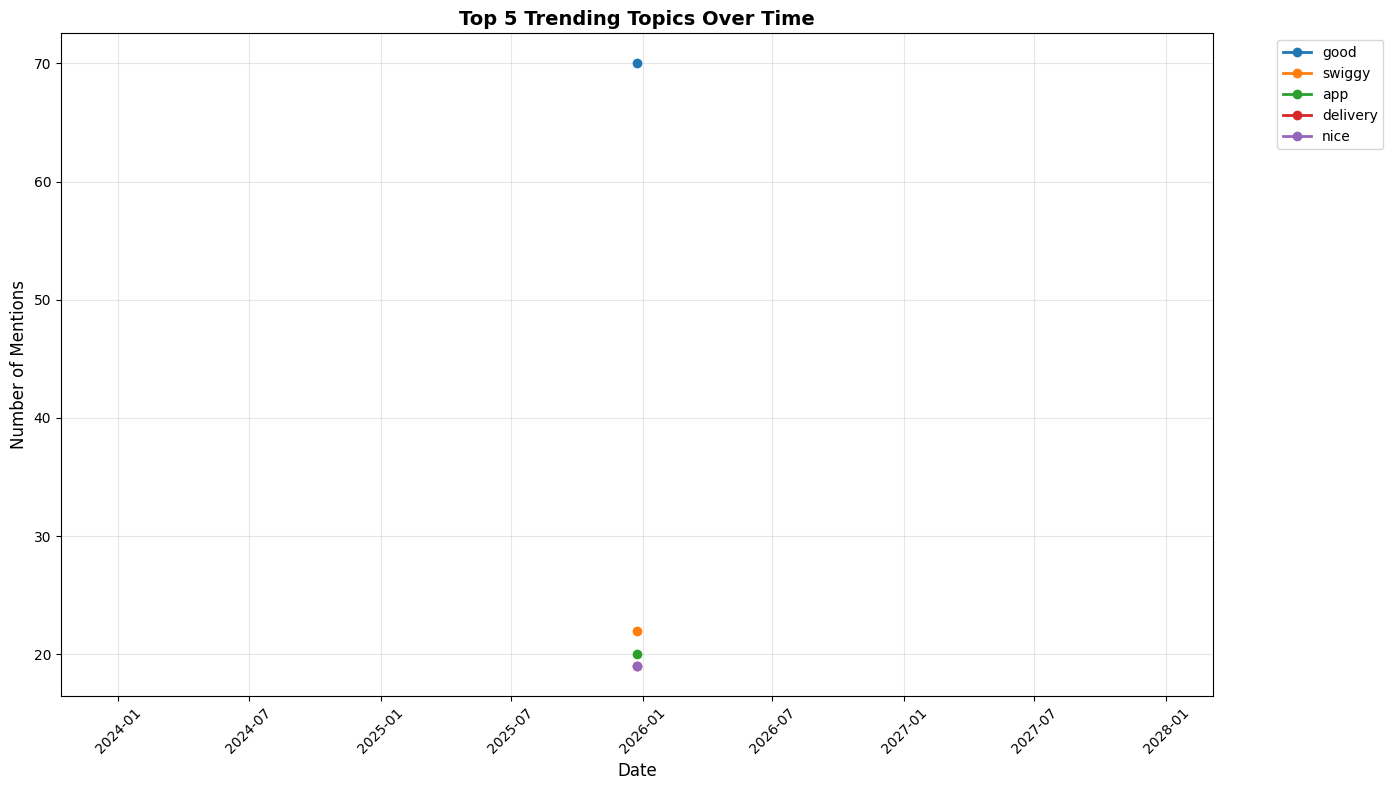


✅ All done! Check the output folder for your reports.


In [50]:
print("\n📊 Generating trend visualization...")

# Select top 5 topics for visualization
top_5_topics = trends_df.head(5)['topic'].tolist()

# Create figure
plt.figure(figsize=(14, 8))

date_cols = [col for col in trend_table.columns if col != 'TOTAL']

for topic in top_5_topics:
    if topic in trend_table.index:
        values = trend_table.loc[topic, date_cols].values
        dates = [pd.to_datetime(d) for d in date_cols]
        plt.plot(dates, values, marker='o', label=topic, linewidth=2)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Mentions', fontsize=12)
plt.title('Top 5 Trending Topics Over Time', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plot_file = os.path.join(OUTPUT_DIR, f"trend_visualization_{target_date.strftime('%Y-%m-%d')}.png")
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"💾 Visualization saved: {plot_file}")

plt.show()

print("\n✅ All done! Check the output folder for your reports.")